# FINAL CLEANING AND DATA QUALITY CHECKS

Along this script we are going to undertake the following tasks:

1. Duplicates analysis
2. Nulls
3. Dates analysis: (outliers,etc)
4. Orders analysis (outliers,etc)

# Importing libraries and storing the dataframe in memory

In [13]:
# Importing packages:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


%matplotlib inline
pd.options.display.max_columns = None

In [14]:
# Defining the search path of the file, the name and the separator:

file_path = "../../data/01_raw/"
file_name = "b2-transactions.csv" #'b2-transactions_sample.csv' 
exit_path = "../../data/02_intermediate/"
original_file_path = file_path + "b2.txt"

# Column names
col_names = ["product_id",
          "description",
          "order_date",
          "section",
          "BmUP",
          "VeUp",
          "CzUP",
          "AaUP",
          "SeUP",
          "JPUP",
          "RzUP",
          "AeUP",
          "LiUP",
          "EnUP",
          "GoUP",
          "GrUP",
          "AnUP",
          "MoUP",
          "PoUP",
          "MsUP",
          "ViUP",
          "ZiUO",
          "GeUP"]
filtered_file_name="c1-filtered_transactions.csv"

sep=";"

In [15]:
target_products_file_name = exit_path + 'filtered_transactions_not_clean.csv' 


In [16]:
df_transactions_filtered = pd.read_csv(target_products_file_name, sep = sep)

In [17]:
df_transactions_filtered.head()

,product_id,description,order_date,section,store,units_ordered,desc_normalized,target_names_prod_by_prod
0,100.0,CROISANTS,1/1/2008 0:00:00,0,VeUp,"20,00",croissant,croissant simple
1,182.0,PALMERAS DE TRUFA,1/1/2008 0:00:00,0,VeUp,"4,00",palmera de trufa,palmera chocolate
2,101.0,CROISSANT,1/1/2008 0:00:00,0,VeUp,"0,00",croissant,croissant simple
3,103.0,CROISSANT PETIT,1/1/2008 0:00:00,0,VeUp,"18,00",croissant petit,croissant petit
4,112.0,TORTELES,1/1/2008 0:00:00,0,VeUp,"60,00",torteles,tortel


In [18]:
df_transactions_filtered.shape

(968107, 8)

In [19]:
df_transactions_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968107 entries, 0 to 968106
Data columns (total 8 columns):
product_id                   968107 non-null float64
description                  968107 non-null object
order_date                   968107 non-null object
section                      968107 non-null int64
store                        968107 non-null object
units_ordered                967793 non-null object
desc_normalized              968107 non-null object
target_names_prod_by_prod    968107 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 59.1+ MB


"order_date" should be date-type but is not, and "units_ordered" should be numeric, but they are not, and there are some nulls... Lets treat the nulls before parsing to the right types. 

Before continuing, lets parse the dataframe to the right column types:

# Parsing column types

### Parsing column "order_date"

In [20]:
# Parsing "order_date" to date type 
df_transactions_filtered["order_date"] = pd.to_datetime(df_transactions_filtered["order_date"])

In [21]:
df_transactions_filtered.head(2)

,product_id,description,order_date,section,store,units_ordered,desc_normalized,target_names_prod_by_prod
0,100.0,CROISANTS,2008-01-01,0,VeUp,"20,00",croissant,croissant simple
1,182.0,PALMERAS DE TRUFA,2008-01-01,0,VeUp,"4,00",palmera de trufa,palmera chocolate


Before cleaning column "units_ordered" we need to clean the null values. Then we will be able to parse it to the right numeric type, which is int.

## NULLs Analysis


In [22]:
df_transactions_filtered.isnull().sum()

product_id                     0
description                    0
order_date                     0
section                        0
store                          0
units_ordered                314
desc_normalized                0
target_names_prod_by_prod      0
dtype: int64

As we saw before, there are only nulls in "units_ordered". The good news is that it does seem to be many of them, lets have a look at it before we decide what to do to them:

After some debate, messy EDA, and careful consideration we decided to eliminate the lines for the following reasons:

1) It is possible that these lines constitute "duplicates" (duplicated in all but their values) for lines that hold a value. If this is the case, these lines would be treated as duplicates in the next step of the quality checks (in which we will see that dropping duplicates is the right move).

2) In case that these lines are not duplicated in the rest of the dataset, removing them will make no difference because we currently don't have the real value of number of units placed in the order, so, when the time comes and we will check for missing value in the series, we will appropriately deal with the matter.

In [23]:
# Proving point 1: lines with nulls may be due to duplicates 
df_original = pd.read_csv(original_file_path, sep = sep, encoding = "ISO-8859-1",names = col_names )
df_original[(df_original["order_date"]=="1/1/2009 0:00:00")&(df_original["description"].str.contains("PALMERAS DE TRUFA"))]

,product_id,description,order_date,section,BmUP,VeUp,CzUP,AaUP,SeUP,JPUP,RzUP,AeUP,LiUP,EnUP,GoUP,GrUP,AnUP,MoUP,PoUP,MsUP,ViUP,ZiUO,GeUP
774282,182.0,PALMERAS DE TRUFA,1/1/2009 0:00:00,0,"2,00","5,00","2,00","2,00","8,00","3,00","2,00","0,00","0,00","3,00","2,00","4,00","4,00","3,00","0,00","0,00","0,00","0,00","0,00"
781175,182.0,PALMERAS DE TRUFA,1/1/2009 0:00:00,0,"0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","5,00","0,00","0,00","0,00"


As mentioned above, the smartest option is to eliminate lines with NaN in the unit ordered: 

In [24]:
df_transactions_filtered_nan_removed = df_transactions_filtered.dropna()

In [25]:
# Check
df_transactions_filtered.shape[0] - 314 == df_transactions_filtered_nan_removed.shape[0]


True

### Parsing column "units_ordered" to int

In [26]:
df_transactions_filtered_nan_removed["units_ordered"]  = df_transactions_filtered_nan_removed["units_ordered"].str.split(",").apply(lambda l: int(l[0]))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [27]:
df_transactions_filtered_nan_removed.head()

,product_id,description,order_date,section,store,units_ordered,desc_normalized,target_names_prod_by_prod
0,100.0,CROISANTS,2008-01-01,0,VeUp,20,croissant,croissant simple
1,182.0,PALMERAS DE TRUFA,2008-01-01,0,VeUp,4,palmera de trufa,palmera chocolate
2,101.0,CROISSANT,2008-01-01,0,VeUp,0,croissant,croissant simple
3,103.0,CROISSANT PETIT,2008-01-01,0,VeUp,18,croissant petit,croissant petit
4,112.0,TORTELES,2008-01-01,0,VeUp,60,torteles,tortel


In [28]:
df_transactions_filtered_nan_removed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 967793 entries, 0 to 968106
Data columns (total 8 columns):
product_id                   967793 non-null float64
description                  967793 non-null object
order_date                   967793 non-null datetime64[ns]
section                      967793 non-null int64
store                        967793 non-null object
units_ordered                967793 non-null int64
desc_normalized              967793 non-null object
target_names_prod_by_prod    967793 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 66.5+ MB


Voila! the types look as they should be looking, and the nulls have been treated. 

# Duplicates Analysis

Lets see if we have any duplicates:

In [29]:
df_transactions_filtered_nan_removed.duplicated().sum() 

120340

Wow! this was unexpected 120.340 duplicates seems as a big number (it is roughly 1/8 of the rows of the Dataset). 

We need to take a closer look to these duplicates:

In [32]:
duplicates = df_transactions_filtered_nan_removed[df_transactions_filtered_nan_removed.duplicated()]
duplicates.head()

,product_id,description,order_date,section,store,units_ordered,desc_normalized,target_names_prod_by_prod
261,182.0,PALMERAS DE TRUFA,2009-01-01,0,ZiUO,0,palmera de trufa,palmera chocolate
292,182.0,PALMERAS DE TRUFA,2009-01-01,0,AeUP,0,palmera de trufa,palmera chocolate
325,182.0,PALMERAS DE TRUFA,2009-01-01,0,ViUP,0,palmera de trufa,palmera chocolate
347,182.0,PALMERAS DE TRUFA,2009-01-01,0,LiUP,0,palmera de trufa,palmera chocolate
358,182.0,PALMERAS DE TRUFA,2009-01-01,0,GeUP,0,palmera de trufa,palmera chocolate


Interesting, it seems that all have 0 units ordered, but lets dig more into this:

In [31]:
duplicates["units_ordered"].value_counts()

0     118025
1       1583
2        255
3         71
6         71
4         65
8         50
10        38
5         32
12        21
15        18
25        12
7         12
20        12
18        12
50         9
30         8
14         7
16         7
40         5
11         4
9          4
13         3
24         3
55         2
22         2
26         2
35         2
70         1
90         1
45         1
64         1
60         1
Name: units_ordered, dtype: int64

Unfortunately, it seems that not all the duplicates are 0, otherwise we could have deleted the duplicates. However we now need to find out a bit more the ones greater than 0. 

Lets explore the original file to see what could have happened:

Lets take for example the duplicate with "units_ordered" = 70:

In [33]:
duplicates[duplicates["units_ordered"]==70]

,product_id,description,order_date,section,store,units_ordered,desc_normalized,target_names_prod_by_prod
396559,112.0,TORTELES,2016-02-20,0,VeUp,70,torteles,tortel


Lets now search for this specific row in the original dataset that the client gave us:

In [34]:
df_original[(df_original["order_date"]=="1/1/2009 0:00:00")&(df_original["description"].str.contains("PALMERAS DE TRUFA"))]

,product_id,description,order_date,section,BmUP,VeUp,CzUP,AaUP,SeUP,JPUP,RzUP,AeUP,LiUP,EnUP,GoUP,GrUP,AnUP,MoUP,PoUP,MsUP,ViUP,ZiUO,GeUP
774282,182.0,PALMERAS DE TRUFA,1/1/2009 0:00:00,0,"2,00","5,00","2,00","2,00","8,00","3,00","2,00","0,00","0,00","3,00","2,00","4,00","4,00","3,00","0,00","0,00","0,00","0,00","0,00"
781175,182.0,PALMERAS DE TRUFA,1/1/2009 0:00:00,0,"0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","5,00","0,00","0,00","0,00"


We consider the theory that many from our duplicates might come from duplicates from the original file.

Lets check it:

In [22]:
df_original.duplicated().sum()

5282

There many duplicates in the original file, but not enough.

As we melted this file to obtain our own (and to have the information as transactions), this number of duplicates has to be multiplied by the number of stores (10), but even then it falls a little shy of the number of duplicates in our results.

Also, when we have into consideration that most of the duplicates should correspond to products that are not in our filtered dataset, we cannot consider duplicates from the original file as the only (or even, the main) source of duplicates in our file.

Diggind deeper in the matter, we are now going to check a couple of values from our duplicates, in the original dataframe provided to us:

In [23]:
df_original[(df_original["order_date"]=="20/2/2016 0:00:00")&(df_original["description"].str.contains("TORTELES"))]

,product_id,description,order_date,section,BmUP,VeUp,CzUP,AaUP,SeUP,JPUP,RzUP,AeUP,LiUP,EnUP,GoUP,GrUP,AnUP,MoUP,PoUP,MsUP,ViUP,ZiUO,GeUP
1462852,112.0,TORTELES,20/2/2016 0:00:00,0,"40,00","70,00","35,00","60,00","36,00","30,00","16,00","0,00","0,00","30,00","0,00","0,00","20,00","20,00","30,00","0,00","0,00","0,00","17,00"
1462883,112.0,TORTELES,20/2/2016 0:00:00,0,"0,00","70,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"


We can see that the bottom line is empty except for the store "VeUp" that has the value repeated. Coincidence or patter? lets dig a bit more:

In [36]:
# Lets take a random one from 
duplicates[duplicates["units_ordered"]==4].sample()

,product_id,description,order_date,section,store,units_ordered,desc_normalized,target_names_prod_by_prod
9432,182.0,PALMERAS DE TRUFA,2015-01-12,0,AnUP,4,palmera de trufa,palmera chocolate


In [25]:
df_original[(df_original["order_date"]=="27/2/2016 0:00:00")&(df_original["description"].str.contains("MILHOJAS"))&(df_original["description"].str.contains("FRAMBUESA"))][["product_id","description","order_date","section","RzUP"]]

,product_id,description,order_date,section,RzUP
1471806,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"1,00"
1471807,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"4,00"
1471808,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"1,00"
1473160,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"4,00"
1473665,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00"
1473671,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00"
1473694,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00"
1473695,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00"
1473778,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00"


This case beneath is very interesting:
    
We can see that for a given produt id, with the same description and on the same order date, there are several orders:

* Some of these orders are duplicates

* Some lines correspond to one order from one specific store, but we have two different orders asking for diffent quantities of the product

In [39]:
df_original[(df_original["order_date"]=="27/2/2016 0:00:00")&(df_original["description"].str.contains("MILHOJAS"))&(df_original["description"].str.contains("FRAMBUESA"))]

,product_id,description,order_date,section,BmUP,VeUp,CzUP,AaUP,SeUP,JPUP,RzUP,AeUP,LiUP,EnUP,GoUP,GrUP,AnUP,MoUP,PoUP,MsUP,ViUP,ZiUO,GeUP
1471806,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00","0,00","0,00","0,00","0,00","0,00","1,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
1471807,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00","0,00","0,00","0,00","0,00","0,00","4,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
1471808,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00","0,00","0,00","0,00","0,00","0,00","1,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
1473160,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"3,00","4,00","0,00","5,00","0,00","2,00","4,00","0,00","0,00","1,00","0,00","0,00","3,00","1,00","3,00","0,00","0,00","0,00","0,00"
1473665,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00","0,00","0,00","1,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
1473671,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00","0,00","0,00","0,00","3,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
1473694,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","1,00","0,00","0,00","0,00","0,00","0,00","0,00"
1473695,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","1,00","0,00","0,00","0,00","0,00","0,00","0,00"
1473778,459.0,MILHOJAS FRAMBUESA 2º,27/2/2016 0:00:00,0,"0,00","0,00","5,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"


Ok..., at this point the information was too confusing: One store, in one day has multiple orders; all very similar.. And when that store is compared to the other stores for the same day, its even more confusing... So we decided to meet with the client and ask for clarifications:

These are the conclusions from the meeting:

 - In the original file, there should only be one line per day, if there are more it could mean two things:
     - if the additional line is all 0 except for one store, AND that store has 0 in the main line, it means that they had to manually input their order in the system.
     - if one store has duplicated orders for a given day-product, it means they made a mistake. 
 - Also, if a store orders different quantities of the same product in the same day, its probably an error and they only take the largest order.
 
 The main conclusion from the client is that we can group by Date - product - store and take the largest order to remove duplicates... HOWEVER, before doing this, we need to take into account another situation: One product could have been ordered by a store, in a given day using several different product id / descriptions. If we group by, we may be loosing orders, unless we are very restrictive. 

In [40]:
#Lets take the max value for each line:
df_non_duplicated_lines = df_transactions_filtered_nan_removed.groupby(['product_id', 'description','order_date', 'section', 'store', 'desc_normalized', 'target_names_prod_by_prod']).max().reset_index()

In [41]:
df_non_duplicated_lines.duplicated().sum()

0

Perfect, we don't have duplicates!... Or yes...

Actually, we may still have duplicates, one store could have created duplicates that we have not identified by ordering the same product by two different ID's or using different descriptions.

- If they were using different ID's this could would mainly mean that they intentionally want two different orders (perhaps custom orders, and normal order)

- If they were using different product descriptions, it would probably mean that they introduced the order two times, however lets explore this situation a bit more:


In [42]:
# Lets count the number of times a duplicated line differs only by the raw desciption, and has a value greater than 0:
aux=df_non_duplicated_lines.drop('description', axis=1)
aux2 = aux[aux.duplicated()]
aux2[aux2["units_ordered"]>0]["units_ordered"].shape

(16,)

In [43]:
aux2["units_ordered"].max()

1

OK, so... the total number of times an order of a given store - day - product differs only by the description is 16 times, hence is safe to remove it from the group by

In [44]:
df_non_duplicated_lines = df_transactions_filtered_nan_removed.groupby(['product_id','order_date', 'section', 'store', 'target_names_prod_by_prod'])["units_ordered"].max().reset_index()

In [45]:
df_non_duplicated_lines.head()

,product_id,order_date,section,store,target_names_prod_by_prod,units_ordered
0,45.0,2017-05-05,0,AaUP,postre de fresas y mascarpone,0
1,45.0,2017-05-05,0,AeUP,postre de fresas y mascarpone,0
2,45.0,2017-05-05,0,AnUP,postre de fresas y mascarpone,0
3,45.0,2017-05-05,0,BmUP,postre de fresas y mascarpone,0
4,45.0,2017-05-05,0,CzUP,postre de fresas y mascarpone,0


In [46]:
df_non_duplicated_lines.duplicated().sum()

0

We are going to check the resulting shape of our dataframe, to do a brief sanity check by seeing how many lines have been deleted:

In [47]:
df_non_duplicated_lines.shape

(742922, 6)

# Data quality:


## 1. File Shape (one line per day-store-product)

The dataset should contain only one line per product, date, and store. However, we already know that one product could have been ordered by given store, in a given day with several products ID's. 

The expectation is that there could be several different orders for the same product, same day and same store, because, as we saw when filtering our products, there were several product IDs for most of them that checked all the boxes of the description, as we can see in the image below (corresponding to the "mousse 3 chocolates"):

<img src=./IM00.png>

lets check it:

In [49]:
# Calculate number of orders by a store in a given day and product that are greater than 2:
aux = df_non_duplicated_lines.groupby(['order_date', 'section', 'store', 'target_names_prod_by_prod'])["product_id"].count()
aux[aux>2].count()

1045

In [50]:
# Calculate number of orders by a store in a given day and product that are greater than 2:
aux = df_non_duplicated_lines.groupby(['order_date', 'section', 'store', 'target_names_prod_by_prod'])["product_id"].count()
aux[aux>2].max()

4

For this orders we are not going to pick the biggest, as before, but sum their quantities: indeed, they have different product ids, but they correspond to the very same product, so adding up the quantities is what will give us the total ammount a particular store orders in a particular day:


In [52]:
df_to_check = df_non_duplicated_lines.groupby(['order_date', 'section', 'store', 'target_names_prod_by_prod'])["units_ordered"].sum().reset_index()
df_to_check.head(20)

,order_date,section,store,target_names_prod_by_prod,units_ordered
0,2008-01-01,0,AaUP,baguette,15
1,2008-01-01,0,AaUP,croissant petit,12
2,2008-01-01,0,AaUP,croissant simple,4
3,2008-01-01,0,AaUP,milhojas frambuesa,1
4,2008-01-01,0,AaUP,mousse tres chocolates,0
5,2008-01-01,0,AaUP,palmera chocolate,5
6,2008-01-01,0,AaUP,tortel,0
7,2008-01-01,0,AeUP,baguette,0
8,2008-01-01,0,AeUP,croissant petit,0
9,2008-01-01,0,AeUP,croissant simple,0


## 2. Checking for outliers:

We are now going to check for outliers in our data.

We are going to undertake this take little by little:

In [54]:
df_to_check['units_ordered'].mean()

4.771253282574057

In [95]:
df_to_check['units_ordered'].max()

4100

In [58]:
df_to_check.sort_values('units_ordered', ascending=False)

,order_date,section,store,target_names_prod_by_prod,units_ordered
19174,2008-05-10,0,EnUP,croissant petit,4100
11935,2008-03-23,0,EnUP,croissant petit,3600
26234,2008-06-26,0,LiUP,croissant petit,3500
229246,2012-03-11,0,EnUP,palmera chocolate,3110
39219,2008-09-24,0,EnUP,croissant petit,3100
38480,2008-09-19,0,LiUP,croissant petit,3000
37169,2008-09-10,0,LiUP,croissant petit,1800
16934,2008-04-25,0,LiUP,croissant petit,1500
3822,2008-01-27,0,EnUP,croissant petit,1200
50583,2008-12-09,0,LiUP,croissant petit,1070


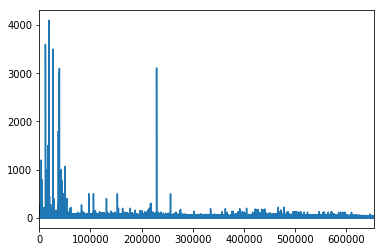

In [60]:
df_to_check['units_ordered'].plot()

In [ ]:
df_to_check

In [90]:
aaa = pd.pivot_table(data=df_for_work, index=['store', 'target_names_prod_by_prod'],)

In [91]:
aaa

section  units_ordered
store target_names_prod_by_prod                            
AaUP  baguette                             0      11.477378
      croissant petit                      0       7.508097
      croissant simple                     0      16.894885
      milhojas frambuesa                   0       2.114654
      mousse tres chocolates               0       0.153201
...                                      ...            ...
ZiUO  palmera chocolate                    0       1.660639
      postre de fresas y mascarpone        0       4.679483
      tarta de manzana                     0       0.000235
      tarta opera                          0       0.000000
      tortel                               0       0.000000

[190 rows x 2 columns]